<a href="https://colab.research.google.com/github/overstep133/Cpp-Primer/blob/master/ICU_Mortality_Prediction_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 ICU Mortality Prediction using Logistic Regression (MIMIC-III via BigQuery)

Author: *Your Name Here*

This notebook demonstrates how to use publicly available MIMIC-III data through BigQuery to predict in-hospital mortality using logistic regression.

👉 You’ll learn: data extraction, preprocessing, model training, and evaluation.

In [2]:
# 🔐 Authenticate with Google
from google.colab import auth
auth.authenticate_user()

In [3]:
# 🛠️ Setup BigQuery Client
project_id = 'physionet-data-464603' # ⛳ Replace with your own GCP project ID
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [4]:
# 📡 Extract features from MIMIC-III (admissions, patients, icustays)
query = """
SELECT
  p.subject_id,
  a.hadm_id,
  i.icustay_id,
  a.hospital_expire_flag,
  DATE_DIFF(a.admittime, p.dob, YEAR) AS age,
  p.gender,
  TIMESTAMP_DIFF(i.outtime, i.intime, HOUR) AS icu_los_hrs
FROM
  `physionet-data.mimiciii_clinical.patients` p
JOIN
  `physionet-data.mimiciii_clinical.admissions` a
  ON p.subject_id = a.subject_id
JOIN
  `physionet-data.mimiciii_clinical.icustays` i
  ON a.hadm_id = i.hadm_id
WHERE
  DATE_DIFF(a.admittime, p.dob, YEAR) BETWEEN 18 AND 90
  AND i.intime IS NOT NULL AND i.outtime IS NOT NULL
LIMIT 10000
"""

df = client.query(query).to_dataframe()
df.head()

,subject_id,hadm_id,icustay_id,hospital_expire_flag,age,gender,icu_los_hrs
0,17623,116439,203872,0,18,F,37
1,21346,104085,242562,0,18,M,38
2,2659,181950,296774,0,18,M,23
3,14930,107736,255640,0,18,F,40
4,51687,153005,224632,0,18,F,44


In [5]:
# 🧹 Data Preprocessing
import pandas as pd
import numpy as np

df = df.dropna()
df['gender'] = df['gender'].map({'M': 0, 'F': 1})
X = df[['age', 'gender', 'icu_los_hrs']]
y = df['hospital_expire_flag']
X.describe()

,age,gender,icu_los_hrs
count,10000.0,10000.000000,10000.0
mean,55.7833,0.412700,103.508
std,18.642518,0.492344,153.233959
min,18.0,0.000000,0.0
25%,43.0,0.000000,29.0
50%,56.0,0.000000,51.0
75%,71.0,1.000000,104.25
max,89.0,1.000000,2804.0


In [6]:
# 📤 Split into Train/Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 🤖 Train Logistic Regression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [8]:
# 📊 Evaluate Model
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93      1727
         1.0       0.00      0.00      0.00       273

    accuracy                           0.86      2000
   macro avg       0.43      0.50      0.46      2000
weighted avg       0.75      0.86      0.80      2000

ROC AUC: 0.6543053549422977


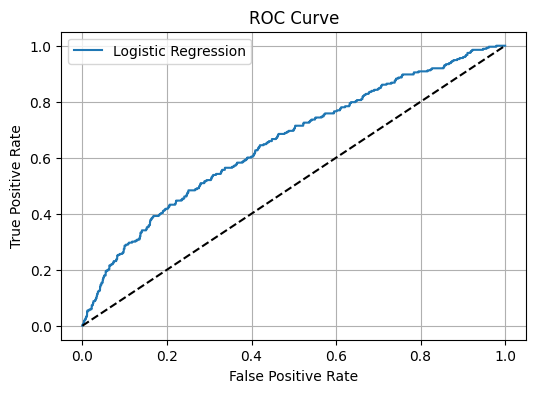

In [9]:
# 📈 Plot ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

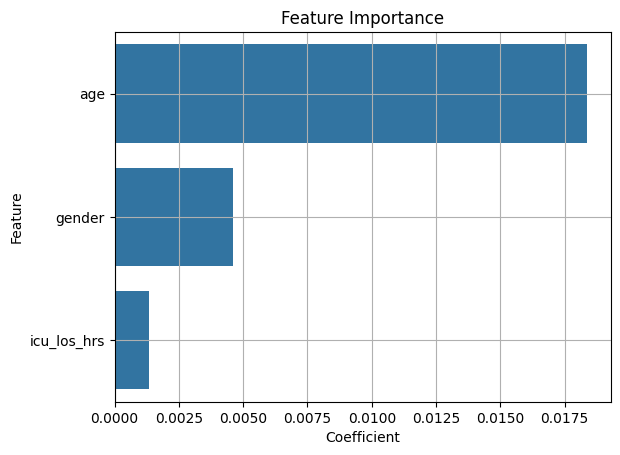

In [10]:
# 🔍 Feature Importance
import seaborn as sns

feature_names = X.columns
coefs = model.coef_[0]

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs
}).sort_values(by="Coefficient", key=np.abs, ascending=False)

sns.barplot(data=importance_df, x="Coefficient", y="Feature")
plt.title("Feature Importance")
plt.grid()
plt.show()